In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 10,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_10_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 10:53 - loss: 0.0805 - STD: 2.6892e-04 - MAE: 0.2735

 15/632 [..............................] - ETA: 2s - loss: 0.0240 - STD: 2.2414e-04 - MAE: 0.1079   

 29/632 [>.............................] - ETA: 2s - loss: 0.0193 - STD: 2.6051e-04 - MAE: 0.0956

 42/632 [>.............................] - ETA: 2s - loss: 0.0173 - STD: 3.2906e-04 - MAE: 0.0886

 58/632 [=>............................] - ETA: 2s - loss: 0.0160 - STD: 4.9141e-04 - MAE: 0.0826

 75/632 [==>...........................] - ETA: 1s - loss: 0.0152 - STD: 9.4600e-04 - MAE: 0.0799

 88/632 [===>..........................] - ETA: 1s - loss: 0.0146 - STD: 0.0019 - MAE: 0.0779    

101/632 [===>..........................] - ETA: 1s - loss: 0.0140 - STD: 0.0047 - MAE: 0.0757

116/632 [====>.........................] - ETA: 1s - loss: 0.0130 - STD: 0.0117 - MAE: 0.0720

130/632 [=====>........................] - ETA: 3s - loss: 0.0120 - STD: 0.0197 - MAE: 0.0684

146/632 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 0.0278 - MAE: 0.0648

163/632 [======>.......................] - ETA: 2s - loss: 0.0102 - STD: 0.0352 - MAE: 0.0617

178/632 [=======>......................] - ETA: 2s - loss: 0.0096 - STD: 0.0408 - MAE: 0.0594

191/632 [========>.....................] - ETA: 2s - loss: 0.0091 - STD: 0.0446 - MAE: 0.0576

205/632 [========>.....................] - ETA: 2s - loss: 0.0086 - STD: 0.0481 - MAE: 0.0558

218/632 [=========>....................] - ETA: 2s - loss: 0.0082 - STD: 0.0514 - MAE: 0.0544

230/632 [=========>....................] - ETA: 2s - loss: 0.0079 - STD: 0.0539 - MAE: 0.0532

242/632 [==========>...................] - ETA: 2s - loss: 0.0076 - STD: 0.0564 - MAE: 0.0520

255/632 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0588 - MAE: 0.0509

268/632 [===========>..................] - ETA: 1s - loss: 0.0071 - STD: 0.0609 - MAE: 0.0499

283/632 [============>.................] - ETA: 1s - loss: 0.0068 - STD: 0.0631 - MAE: 0.0487

296/632 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0649 - MAE: 0.0479

308/632 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0664 - MAE: 0.0472

324/632 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0463

340/632 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0455

356/632 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0715 - MAE: 0.0447

373/632 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0731 - MAE: 0.0440

390/632 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0744 - MAE: 0.0433

407/632 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0756 - MAE: 0.0427

424/632 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0767 - MAE: 0.0421

440/632 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0776 - MAE: 0.0416

456/632 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0785 - MAE: 0.0411

473/632 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0794 - MAE: 0.0406

490/632 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0402

507/632 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0812 - MAE: 0.0398

524/632 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0394

540/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0390

553/632 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0832 - MAE: 0.0387

567/632 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0837 - MAE: 0.0384

583/632 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0381

598/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0379

613/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0853 - MAE: 0.0376

628/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0858 - MAE: 0.0374

632/632 [==============================] - 4s 5ms/step - loss: 0.0040 - STD: 0.0859 - MAE: 0.0373 - val_loss: 0.0017 - val_STD: 0.0744 - val_MAE: 0.0300


Epoch 2/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0018 - STD: 0.0908 - MAE: 0.0308

 16/632 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0281 

 31/632 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

 44/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0280

 58/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

 75/632 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

 88/632 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

102/632 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

120/632 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

136/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

153/632 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

170/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

186/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

203/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

221/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

239/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

257/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

274/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

292/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

310/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

327/632 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

344/632 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

361/632 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

378/632 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

395/632 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

409/632 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

425/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

443/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

460/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

476/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

494/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

511/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

528/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

545/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

563/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

582/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

600/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

618/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

632/632 [==============================] - 2s 3ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270 - val_loss: 0.0017 - val_STD: 0.0809 - val_MAE: 0.0290


Epoch 3/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0264

 16/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0264 

 33/632 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0263

 48/632 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0262

 60/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0263

 73/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0262

 86/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

101/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0262

118/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

136/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

151/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

164/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

177/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

191/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

208/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

225/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

242/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

258/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

274/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

291/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

325/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

341/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

356/632 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

371/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

387/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

404/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

421/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

438/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

453/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

467/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

482/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

500/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

518/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

536/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

554/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

572/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

590/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

608/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

625/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

632/632 [==============================] - 2s 4ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264 - val_loss: 0.0021 - val_STD: 0.0839 - val_MAE: 0.0311


Epoch 4/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0260

 14/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0260 

 29/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0261

 46/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0261

 63/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0261

 80/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0261

 97/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0261

114/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0260

130/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0260

145/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0260

160/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

176/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

192/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

208/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

223/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

236/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

253/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

270/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

282/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

295/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

322/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

334/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

346/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

359/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

374/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

387/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

401/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

416/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

430/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

443/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

456/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

469/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

482/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

497/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

513/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

530/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

547/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

564/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

578/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

591/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

604/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

617/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

631/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

632/632 [==============================] - 2s 4ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258 - val_loss: 0.0018 - val_STD: 0.0834 - val_MAE: 0.0299


Epoch 5/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0015 - STD: 0.1146 - MAE: 0.0265

 14/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0255 

 31/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

 48/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

 65/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

 78/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

 91/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

106/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

119/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

134/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

149/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

164/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

178/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

191/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

205/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

220/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

237/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

255/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

272/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

285/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

299/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

316/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

333/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

350/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

368/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

384/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

400/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

414/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

430/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

446/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

462/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

478/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

495/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

508/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

523/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

540/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

555/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

568/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

583/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

596/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

609/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

623/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

632/632 [==============================] - 2s 4ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0014 - val_STD: 0.0818 - val_MAE: 0.0266


Epoch 6/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0013 - STD: 0.0962 - MAE: 0.0241

 14/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256 

 30/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

 47/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

 64/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

 80/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

 97/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

114/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

129/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0254

146/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0253

163/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0252

179/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

193/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

209/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

223/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

240/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

257/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

274/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

291/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

305/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

321/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

338/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

354/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

371/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

384/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

400/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

412/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

425/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

440/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

453/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

470/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

487/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

503/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

519/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

535/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

548/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

563/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

579/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

594/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

608/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

625/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

632/632 [==============================] - 2s 4ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251 - val_loss: 0.0016 - val_STD: 0.0839 - val_MAE: 0.0277


Epoch 7/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1124 - MAE: 0.0255

 18/632 [..............................] - ETA: 1s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0248 

 32/632 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0247

 46/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0246

 64/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

 82/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

 99/632 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

118/632 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

136/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

153/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

171/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

189/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

207/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

225/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

242/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

259/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

276/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

293/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

309/632 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

325/632 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

342/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

358/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

375/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

391/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

407/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

424/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

441/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

457/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

474/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

491/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

508/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

524/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

540/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

557/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

573/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

591/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

609/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

627/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

632/632 [==============================] - 2s 3ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249 - val_loss: 0.0013 - val_STD: 0.0790 - val_MAE: 0.0258


Epoch 8/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0012 - STD: 0.0997 - MAE: 0.0238

 16/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244 

 33/632 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0240

 48/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0240

 65/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0242

 82/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0241

100/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

117/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0242

132/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0245

150/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

167/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

185/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

201/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

213/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

226/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

242/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

254/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

267/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

279/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

292/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

306/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

322/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

337/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

354/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0245

371/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

388/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

406/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

423/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

441/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

458/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

475/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

491/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

508/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

526/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

543/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

560/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

574/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

588/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

601/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

615/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

631/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

632/632 [==============================] - 2s 4ms/step - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243 - val_loss: 0.0017 - val_STD: 0.0861 - val_MAE: 0.0284


Epoch 9/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

 17/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242 

 32/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

 46/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0239

 60/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

 78/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

 93/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0238

111/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0239

129/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0240

147/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0240

165/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

183/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

201/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

219/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

237/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

255/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

272/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

290/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

308/632 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

326/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

344/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

362/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

380/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

398/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

416/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

433/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

450/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

465/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

482/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

499/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0240

512/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0240

524/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0240

538/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

556/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

572/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

591/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

609/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

625/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

632/632 [==============================] - 2s 3ms/step - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239 - val_loss: 0.0016 - val_STD: 0.0842 - val_MAE: 0.0280


Epoch 10/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0011 - STD: 0.1087 - MAE: 0.0230

 15/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0244 

 31/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

 49/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0239

 67/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

 84/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

101/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

119/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

136/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

154/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

171/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

185/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

198/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

212/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

226/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0238

242/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

259/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

275/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

289/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

301/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

316/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

333/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

349/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

366/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

380/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

393/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

408/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

425/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

438/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

451/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

466/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

478/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

490/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

502/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

517/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

530/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

544/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

560/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

577/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

594/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

608/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

621/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

632/632 [==============================] - 2s 4ms/step - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237 - val_loss: 0.0015 - val_STD: 0.0854 - val_MAE: 0.0263


Epoch 11/10000


  1/632 [..............................] - ETA: 11s - loss: 8.8031e-04 - STD: 0.1003 - MAE: 0.0211

 14/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1092 - MAE: 0.0230     

 27/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1086 - MAE: 0.0232

 42/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0235

 58/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

 74/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

 90/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

108/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

125/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

141/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

155/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

169/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

182/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

199/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

215/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

231/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

248/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

265/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

279/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

293/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

309/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0234

326/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0234

343/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0234

359/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0234

373/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

390/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

402/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

419/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

436/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

453/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

471/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

488/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

506/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

523/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

540/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

558/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

575/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

590/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

603/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

620/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

632/632 [==============================] - 2s 4ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234 - val_loss: 0.0017 - val_STD: 0.0866 - val_MAE: 0.0280


Epoch 12/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0012 - STD: 0.1021 - MAE: 0.0231

 17/632 [..............................] - ETA: 1s - loss: 0.0011 - STD: 0.1088 - MAE: 0.0231 

 35/632 [>.............................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

 53/632 [=>............................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

 70/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0232

 87/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0233

105/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

123/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

140/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

157/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

175/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

193/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

211/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

229/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

247/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

265/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

284/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

302/632 [=============>................] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

321/632 [==============>...............] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

340/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

358/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

377/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

396/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

414/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

432/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

451/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

470/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

489/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

507/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

525/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

544/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

562/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

579/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

596/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

614/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

631/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

632/632 [==============================] - 2s 3ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231 - val_loss: 0.0015 - val_STD: 0.0858 - val_MAE: 0.0266


Epoch 13/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0010 - STD: 0.0973 - MAE: 0.0228

 17/632 [..............................] - ETA: 1s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0232 

 33/632 [>.............................] - ETA: 1s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0231

 50/632 [=>............................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0229

 68/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0228

 85/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0228

103/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

121/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0229

135/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

147/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

159/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

173/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

191/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

209/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

227/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

245/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

263/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

280/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

296/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

314/632 [=============>................] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

332/632 [==============>...............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

350/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

368/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

386/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

404/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

422/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

440/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

458/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

476/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

494/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

512/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

530/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

548/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

565/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

583/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

601/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

619/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

632/632 [==============================] - 2s 3ms/step - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229 - val_loss: 0.0016 - val_STD: 0.0850 - val_MAE: 0.0272


Epoch 14/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

 17/632 [..............................] - ETA: 1s - loss: 0.0011 - STD: 0.1087 - MAE: 0.0233 

 34/632 [>.............................] - ETA: 1s - loss: 0.0011 - STD: 0.1091 - MAE: 0.0236

 48/632 [=>............................] - ETA: 1s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0233

 65/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0231

 83/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0231

 96/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0230

108/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

120/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0229

133/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

146/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

161/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0229

177/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

193/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

205/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

217/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

233/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

246/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

260/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

273/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0227

287/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

300/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

312/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

324/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

336/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

348/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

364/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

379/632 [================>.............] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

392/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

408/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

421/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

434/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

446/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

459/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

471/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

484/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

498/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

514/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

531/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

550/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

568/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

584/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

600/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

618/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

632/632 [==============================] - 2s 4ms/step - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226 - val_loss: 0.0023 - val_STD: 0.0903 - val_MAE: 0.0307


Epoch 15/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0010 - STD: 0.1236 - MAE: 0.0220

 16/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1090 - MAE: 0.0237 

 32/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1082 - MAE: 0.0232

 46/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1082 - MAE: 0.0230

 60/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0229

 77/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0228

 92/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

107/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1074 - MAE: 0.0226

124/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

142/632 [=====>........................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

159/632 [======>.......................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

176/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

194/632 [========>.....................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

212/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0225

230/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

248/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

265/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

282/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

300/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

317/632 [==============>...............] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

332/632 [==============>...............] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

349/632 [===============>..............] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

366/632 [================>.............] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

383/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

396/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

410/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

425/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

441/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

456/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

473/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

490/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

508/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

525/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

542/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

558/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

576/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

592/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

610/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

626/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

632/632 [==============================] - 2s 3ms/step - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225 - val_loss: 0.0018 - val_STD: 0.0856 - val_MAE: 0.0281


Epoch 16/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0011 - STD: 0.1055 - MAE: 0.0228

 18/632 [..............................] - ETA: 1s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0225 

 35/632 [>.............................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0222

 52/632 [=>............................] - ETA: 1s - loss: 0.0010 - STD: 0.1070 - MAE: 0.0225

 68/632 [==>...........................] - ETA: 1s - loss: 0.0010 - STD: 0.1070 - MAE: 0.0225

 84/632 [==>...........................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0224

101/632 [===>..........................] - ETA: 1s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0224

117/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

134/632 [=====>........................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

150/632 [======>.......................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0223

166/632 [======>.......................] - ETA: 1s - loss: 0.0010 - STD: 0.1073 - MAE: 0.0223

181/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0223

197/632 [========>.....................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0222

213/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

228/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

243/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

260/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

277/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223

295/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223

313/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223

331/632 [==============>...............] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0223

349/632 [===============>..............] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0222

367/632 [================>.............] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0222

384/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223

400/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

417/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

435/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

452/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

469/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

485/632 [======================>.......] - ETA: 0s - loss: 9.9984e-04 - STD: 0.1078 - MAE: 0.0222

502/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222    

518/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

534/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

551/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

568/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

584/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

600/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

617/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

632/632 [==============================] - 2s 3ms/step - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223 - val_loss: 0.0017 - val_STD: 0.0870 - val_MAE: 0.0276


Epoch 17/10000


  1/632 [..............................] - ETA: 11s - loss: 9.9573e-04 - STD: 0.1123 - MAE: 0.0219

 18/632 [..............................] - ETA: 1s - loss: 9.2779e-04 - STD: 0.1085 - MAE: 0.0215 

 34/632 [>.............................] - ETA: 1s - loss: 9.3812e-04 - STD: 0.1086 - MAE: 0.0216

 52/632 [=>............................] - ETA: 1s - loss: 9.3910e-04 - STD: 0.1086 - MAE: 0.0216

 70/632 [==>...........................] - ETA: 1s - loss: 9.5115e-04 - STD: 0.1083 - MAE: 0.0217

 88/632 [===>..........................] - ETA: 1s - loss: 9.5781e-04 - STD: 0.1083 - MAE: 0.0218

106/632 [====>.........................] - ETA: 1s - loss: 9.5878e-04 - STD: 0.1084 - MAE: 0.0218

124/632 [====>.........................] - ETA: 1s - loss: 9.5508e-04 - STD: 0.1085 - MAE: 0.0218

142/632 [=====>........................] - ETA: 1s - loss: 9.5469e-04 - STD: 0.1085 - MAE: 0.0218

160/632 [======>.......................] - ETA: 1s - loss: 9.7319e-04 - STD: 0.1082 - MAE: 0.0220

178/632 [=======>......................] - ETA: 1s - loss: 9.8744e-04 - STD: 0.1082 - MAE: 0.0221

195/632 [========>.....................] - ETA: 1s - loss: 9.8857e-04 - STD: 0.1084 - MAE: 0.0221

213/632 [=========>....................] - ETA: 1s - loss: 9.9249e-04 - STD: 0.1082 - MAE: 0.0222

231/632 [=========>....................] - ETA: 1s - loss: 9.8900e-04 - STD: 0.1081 - MAE: 0.0221

248/632 [==========>...................] - ETA: 1s - loss: 9.8794e-04 - STD: 0.1081 - MAE: 0.0221

264/632 [===========>..................] - ETA: 1s - loss: 9.8835e-04 - STD: 0.1080 - MAE: 0.0221

280/632 [============>.................] - ETA: 1s - loss: 9.8693e-04 - STD: 0.1080 - MAE: 0.0221

296/632 [=============>................] - ETA: 0s - loss: 9.8891e-04 - STD: 0.1079 - MAE: 0.0221

312/632 [=============>................] - ETA: 0s - loss: 9.8652e-04 - STD: 0.1078 - MAE: 0.0221

328/632 [==============>...............] - ETA: 0s - loss: 9.8352e-04 - STD: 0.1078 - MAE: 0.0221

345/632 [===============>..............] - ETA: 0s - loss: 9.8343e-04 - STD: 0.1078 - MAE: 0.0221

363/632 [================>.............] - ETA: 0s - loss: 9.8220e-04 - STD: 0.1079 - MAE: 0.0221

381/632 [=================>............] - ETA: 0s - loss: 9.8471e-04 - STD: 0.1079 - MAE: 0.0221

398/632 [=================>............] - ETA: 0s - loss: 9.8739e-04 - STD: 0.1079 - MAE: 0.0221

413/632 [==================>...........] - ETA: 0s - loss: 9.8655e-04 - STD: 0.1079 - MAE: 0.0221

429/632 [===================>..........] - ETA: 0s - loss: 9.8626e-04 - STD: 0.1079 - MAE: 0.0221

446/632 [====================>.........] - ETA: 0s - loss: 9.8693e-04 - STD: 0.1079 - MAE: 0.0221

463/632 [====================>.........] - ETA: 0s - loss: 9.8780e-04 - STD: 0.1080 - MAE: 0.0221

480/632 [=====================>........] - ETA: 0s - loss: 9.9008e-04 - STD: 0.1079 - MAE: 0.0222

497/632 [======================>.......] - ETA: 0s - loss: 9.8927e-04 - STD: 0.1078 - MAE: 0.0222

515/632 [=======================>......] - ETA: 0s - loss: 9.8795e-04 - STD: 0.1079 - MAE: 0.0221

532/632 [========================>.....] - ETA: 0s - loss: 9.8554e-04 - STD: 0.1079 - MAE: 0.0221

549/632 [=========================>....] - ETA: 0s - loss: 9.8422e-04 - STD: 0.1078 - MAE: 0.0221

566/632 [=========================>....] - ETA: 0s - loss: 9.8406e-04 - STD: 0.1079 - MAE: 0.0221

581/632 [==========================>...] - ETA: 0s - loss: 9.8446e-04 - STD: 0.1079 - MAE: 0.0221

595/632 [===========================>..] - ETA: 0s - loss: 9.8525e-04 - STD: 0.1079 - MAE: 0.0221

610/632 [===========================>..] - ETA: 0s - loss: 9.8536e-04 - STD: 0.1079 - MAE: 0.0221

626/632 [============================>.] - ETA: 0s - loss: 9.8511e-04 - STD: 0.1079 - MAE: 0.0221

632/632 [==============================] - 2s 3ms/step - loss: 9.8474e-04 - STD: 0.1079 - MAE: 0.0221 - val_loss: 0.0018 - val_STD: 0.0871 - val_MAE: 0.0278


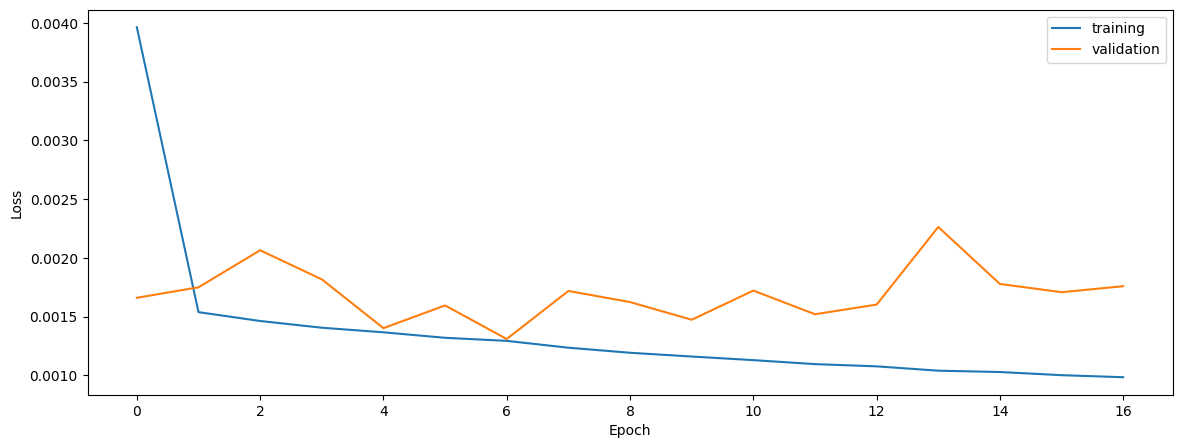

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


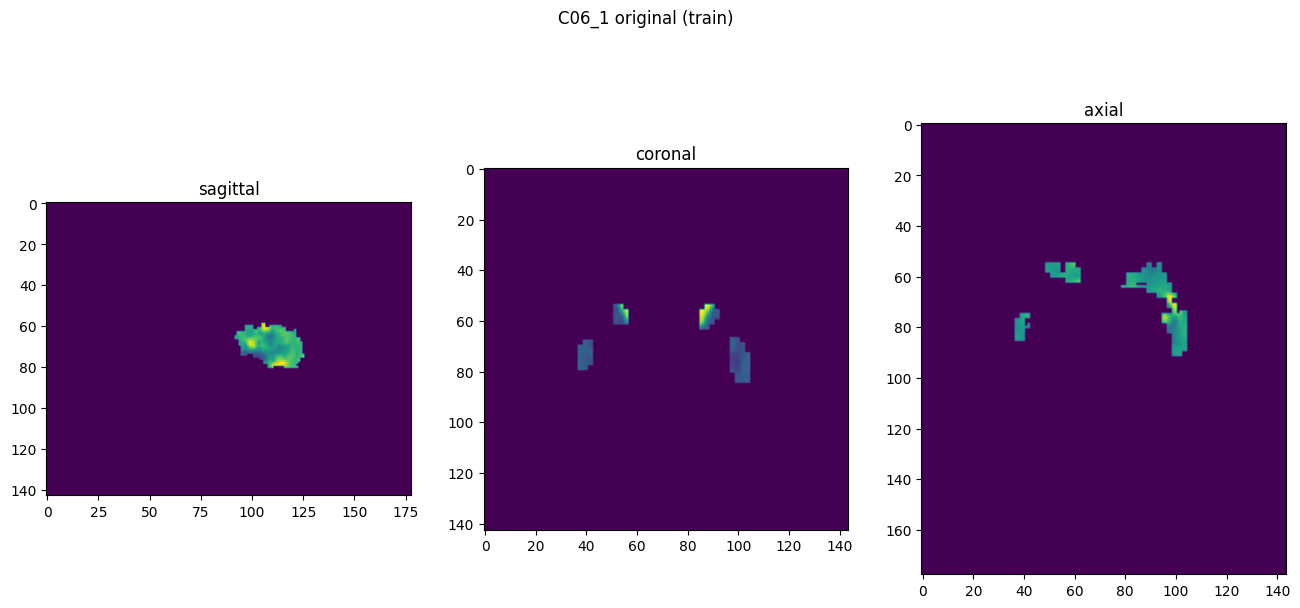

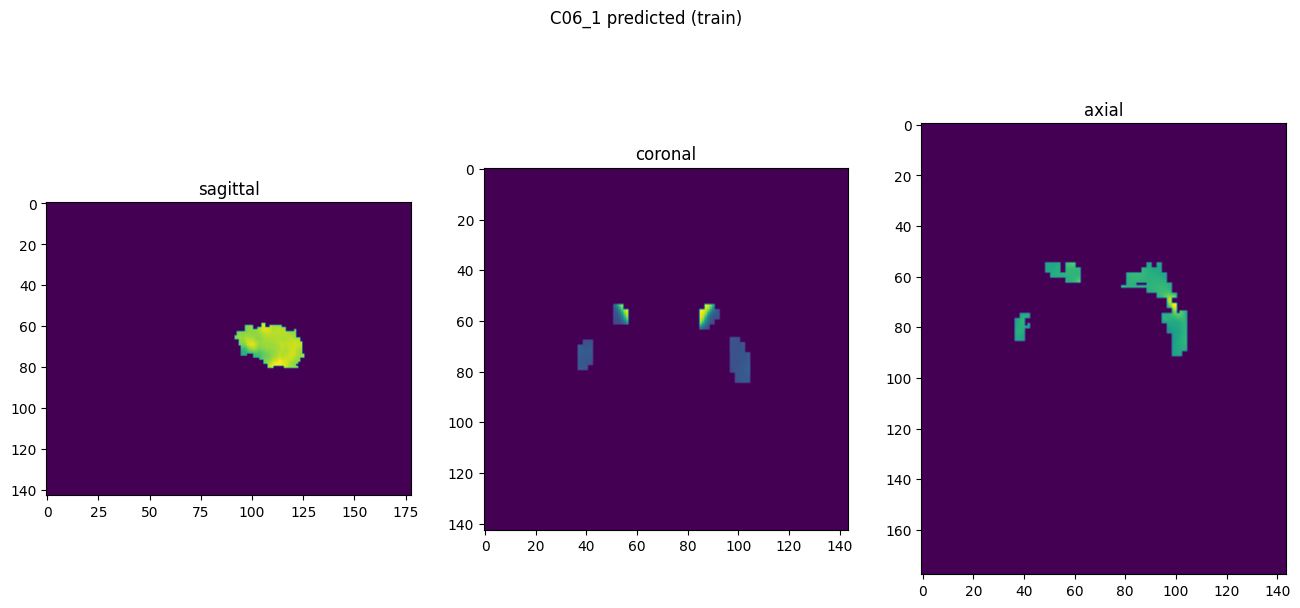

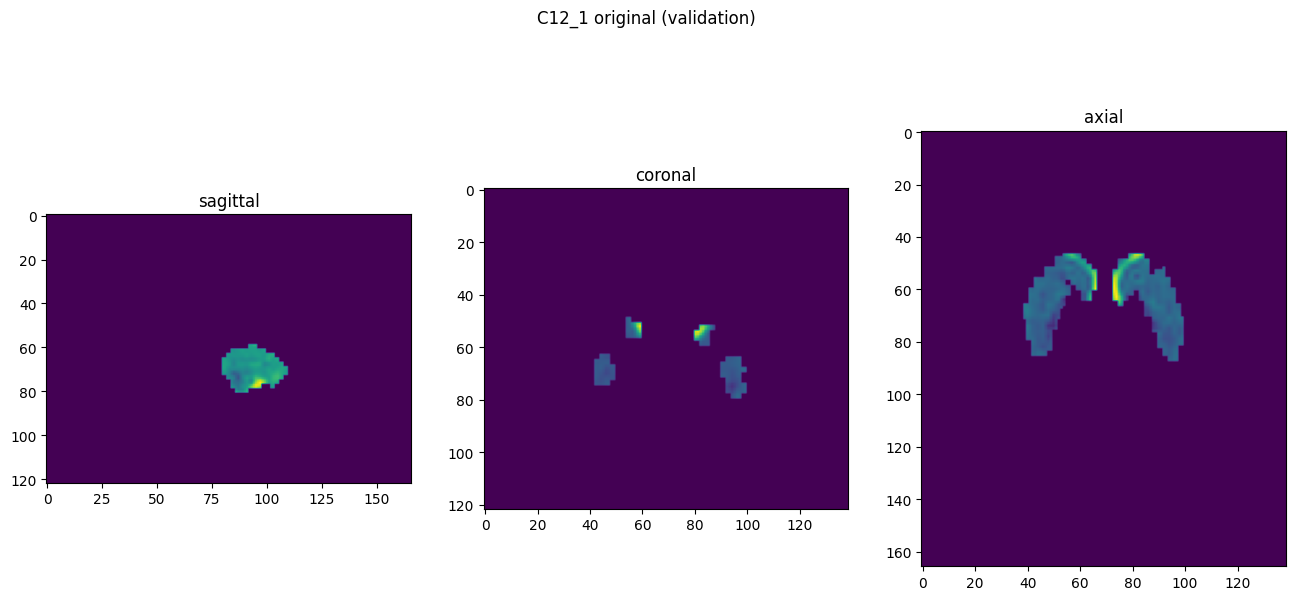

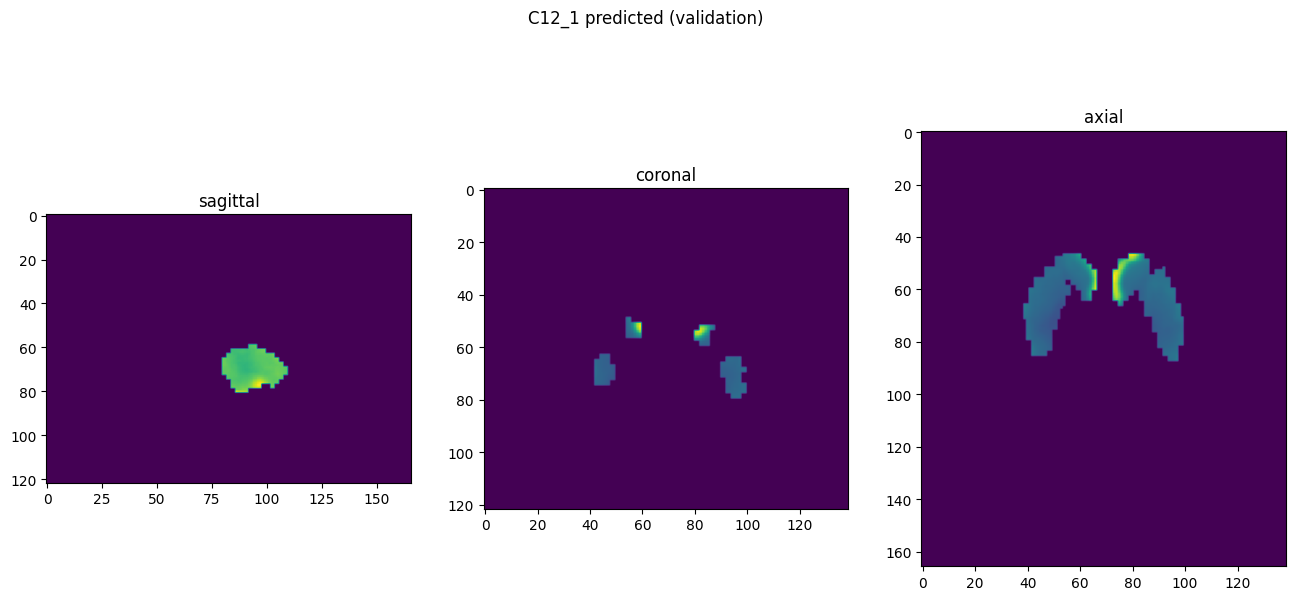

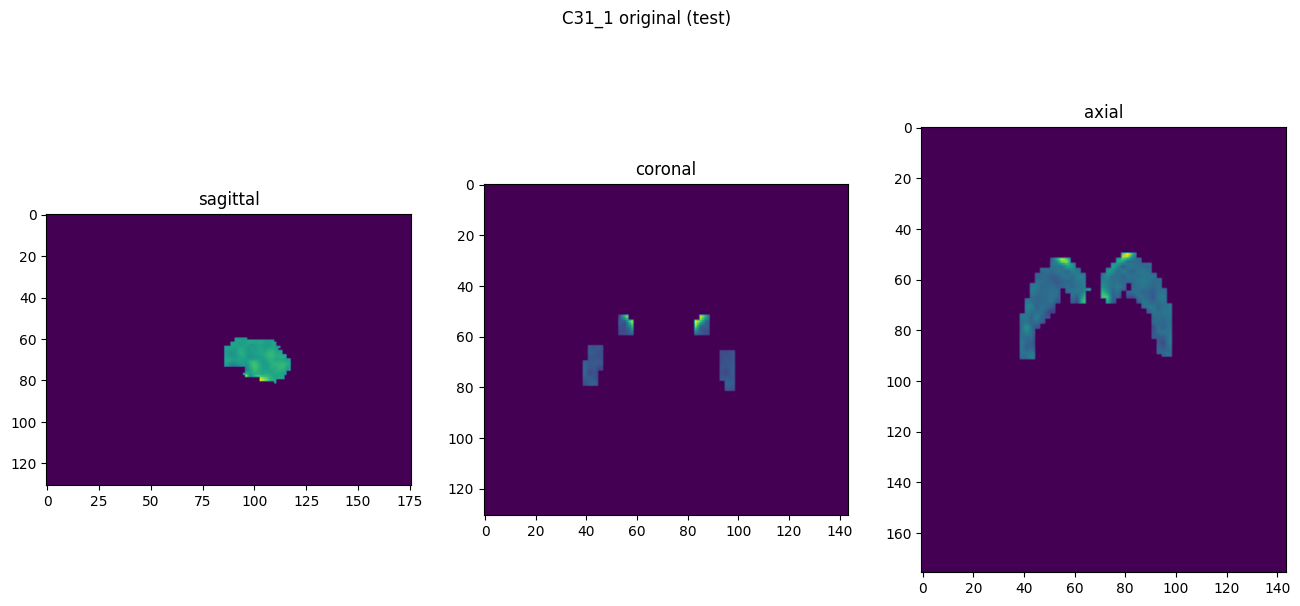

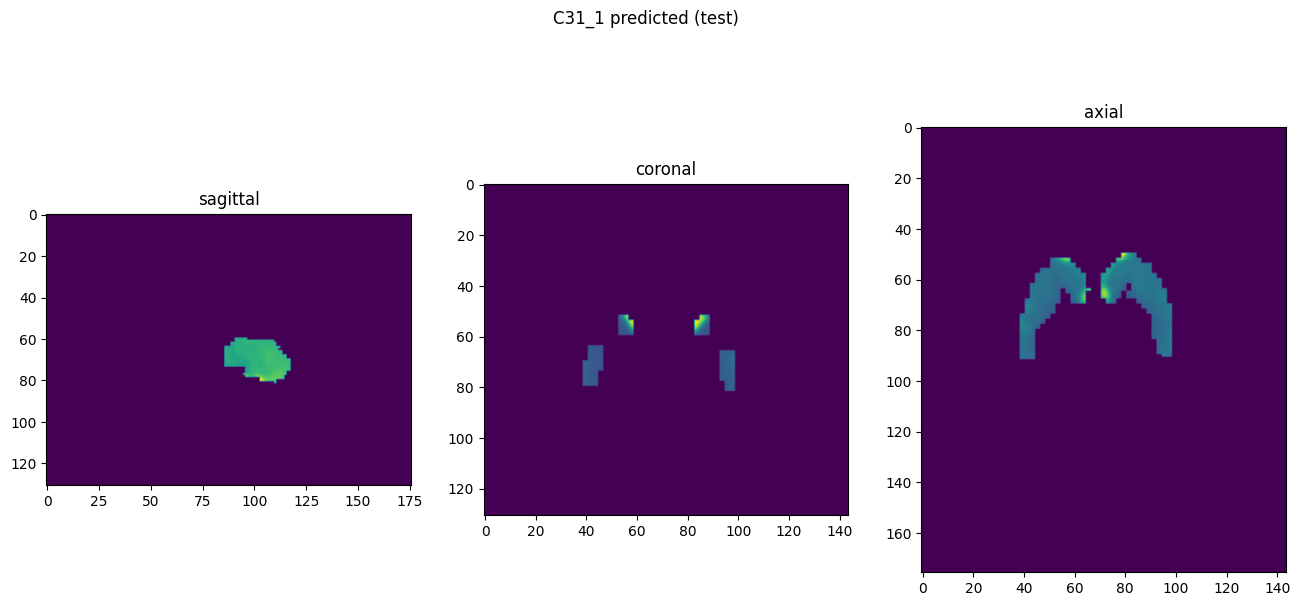

In [10]:
showResults(model, gen, threshold=None, background=False)